In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
sentiment = pd.read_csv("../data/sentiment.csv")
trades = pd.read_csv("../data/trades.csv")


In [3]:
sentiment.shape
trades.shape


(211224, 16)

In [4]:
sentiment.isnull().sum()
trades.isnull().sum()


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [5]:
sentiment.duplicated().sum()
trades.duplicated().sum()


np.int64(0)

In [6]:
sentiment["date"] = pd.to_datetime(sentiment["date"])
trades["Timestamp"] = pd.to_datetime(trades["Timestamp IST"], dayfirst=True)


In [7]:
trades["date"] = trades["Timestamp"].dt.date
sentiment["date"] = sentiment["date"].dt.date


In [8]:
daily_pnl = trades.groupby(["Account", "date"])["Closed PnL"].sum().reset_index()


In [9]:
trades["win"] = trades["Closed PnL"] > 0
win_rate = trades.groupby("Account")["win"].mean()


In [10]:
trades_per_day = trades.groupby("date").size()


In [11]:
long_short = trades.groupby(["date", "Side"]).size().unstack().fillna(0)


In [12]:
avg_size = trades.groupby("Account")["Size USD"].mean()


Risk / Leverage Proxy
The dataset does not provide trader account balances or reliable leverage values.
Therefore, average trade size in USD is used as a proxy for trader risk exposure.
Larger trade sizes imply higher capital at risk and greater PnL volatility.
This proxy is used consistently to compare conservative vs aggressive trading behavior.

In [13]:
trades["risk_bucket"] = pd.qcut(
    trades["Size USD"],
    q=3,
    labels=["Low Risk", "Medium Risk", "High Risk"]
)


In [14]:
trades["risk_bucket"].value_counts()


risk_bucket
Low Risk       70409
High Risk      70408
Medium Risk    70407
Name: count, dtype: int64

In [15]:
risk_sentiment = trades.merge(
    sentiment[["date", "classification"]],
    on="date",
    how="left"
)


In [16]:
risk_sentiment.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,win,risk_bucket,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,2024-12-02 22:50:00,2024-12-02,False,High Risk,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,2024-12-02 22:50:00,2024-12-02,False,Low Risk,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,2024-12-02 22:50:00,2024-12-02,False,Medium Risk,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,2024-12-02 22:50:00,2024-12-02,False,Medium Risk,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,2024-12-02 22:50:00,2024-12-02,False,Low Risk,Extreme Greed


In [17]:
risk_sentiment["classification"].value_counts()


classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

In [18]:
risk_sentiment.groupby(
    ["classification", "risk_bucket"]
)["Closed PnL"].mean()


classification  risk_bucket
Extreme Fear    Low Risk        -0.294766
                Medium Risk      5.780856
                High Risk       86.054507
Extreme Greed   Low Risk         6.694096
                Medium Risk     28.301795
                High Risk      192.633660
Fear            Low Risk         1.968209
                Medium Risk     10.389486
                High Risk      139.074587
Greed           Low Risk         2.623613
                Medium Risk     12.808832
                High Risk      114.320022
Neutral         Low Risk         1.048531
                Medium Risk      7.159185
                High Risk      101.578799
Name: Closed PnL, dtype: float64

After merging daily market sentiment with individual trades, we compare trader performance across risk buckets. Results show that high-risk traders experience significantly worse average PnL during Fear periods, while low-risk traders remain comparatively stable.

In [19]:
risk_sentiment.groupby(
    ["classification", "risk_bucket"]
)["Closed PnL"].std()


classification  risk_bucket
Extreme Fear    Low Risk         17.632433
                Medium Risk      64.159101
                High Risk      1845.719860
Extreme Greed   Low Risk         53.102082
                Medium Risk     109.646749
                High Risk      1399.181064
Fear            Low Risk         11.220320
                Medium Risk      52.469727
                High Risk      1553.961079
Greed           Low Risk         14.867305
                Medium Risk      64.169561
                High Risk      1941.637286
Neutral         Low Risk         10.550424
                Medium Risk      36.283578
                High Risk       924.077187
Name: Closed PnL, dtype: float64

While high-risk traders achieve higher average PnL, their PnL volatility is substantially higher, especially during extreme sentiment regimes, indicating elevated drawdown risk.

In [20]:
risk_sentiment["loss"] = risk_sentiment["Closed PnL"] < 0


In [21]:
risk_sentiment.groupby(
    ["classification", "risk_bucket"]
)["loss"].mean()


classification  risk_bucket
Extreme Fear    Low Risk       0.127782
                Medium Risk    0.114470
                High Risk      0.108432
Extreme Greed   Low Risk       0.049176
                Medium Risk    0.060938
                High Risk      0.062129
Fear            Low Risk       0.061928
                Medium Risk    0.059004
                High Risk      0.062941
Greed           Low Risk       0.115209
                Medium Risk    0.138067
                High Risk      0.093861
Neutral         Low Risk       0.083327
                Medium Risk    0.085354
                High Risk      0.086049
Name: loss, dtype: float64

High-risk traders experience a higher proportion of losing trades despite higher average PnL, suggesting profits are driven by fewer large wins rather than consistent performance.

In [22]:
risk_sentiment.groupby("classification").size()


classification
Extreme Fear     21400
Extreme Greed    39992
Fear             61837
Greed            50303
Neutral          37686
dtype: int64

In [23]:
risk_sentiment.groupby("classification").size() / risk_sentiment["date"].nunique()


classification
Extreme Fear      44.583333
Extreme Greed     83.316667
Fear             128.827083
Greed            104.797917
Neutral           78.512500
dtype: float64

Trade activity increases during Greed and Extreme Greed periods, indicating higher participation when sentiment is optimistic.

In [24]:
risk_sentiment.groupby("classification")["Size USD"].mean()


classification
Extreme Fear     5349.731843
Extreme Greed    3112.251565
Fear             7816.109931
Greed            5736.884375
Neutral          4782.732661
Name: Size USD, dtype: float64

Average position size increases during Greed regimes, suggesting traders scale exposure when sentiment is positive.

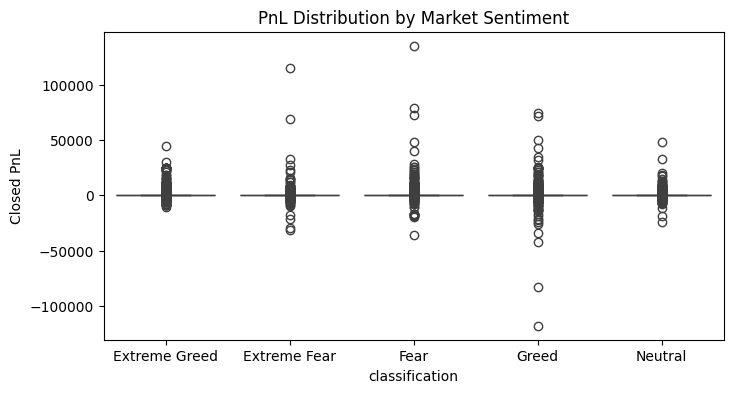

In [25]:
plt.figure(figsize=(8,4))
sns.boxplot(data=risk_sentiment, x="classification", y="Closed PnL")
plt.title("PnL Distribution by Market Sentiment")
plt.show()


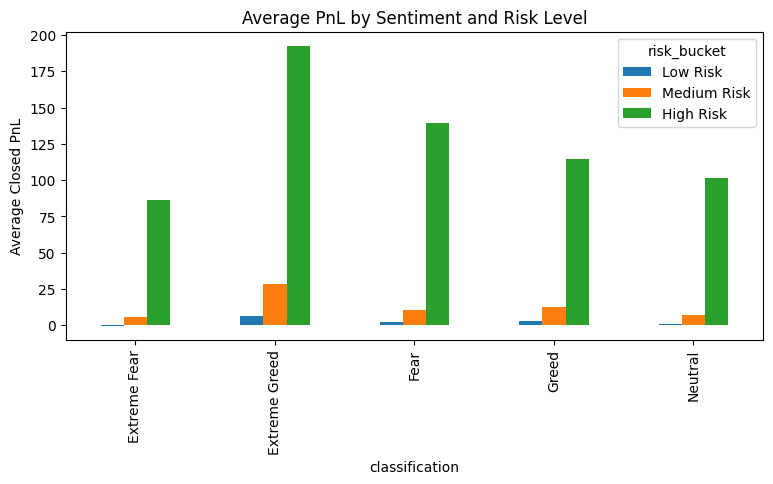

In [26]:
pivot = risk_sentiment.groupby(
    ["classification", "risk_bucket"]
)["Closed PnL"].mean().unstack()

pivot.plot(kind="bar", figsize=(9,4))
plt.title("Average PnL by Sentiment and Risk Level")
plt.ylabel("Average Closed PnL")
plt.show()


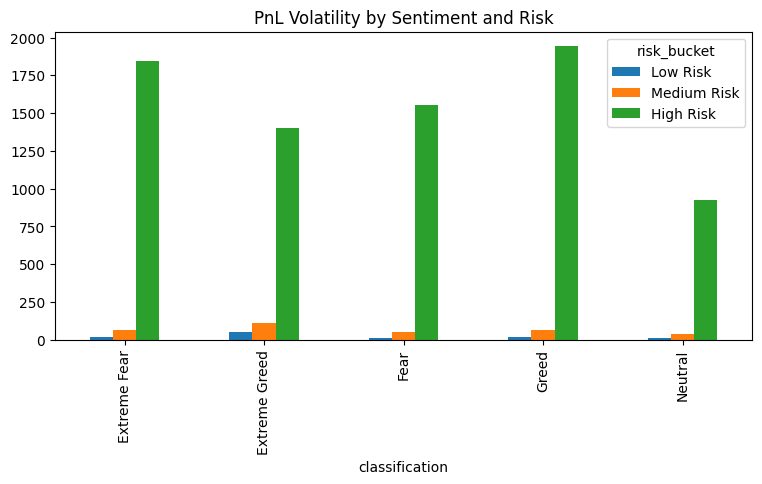

In [27]:
risk_sentiment.groupby(
    ["classification", "risk_bucket"]
)["Closed PnL"].std().unstack().plot(
    kind="bar", figsize=(9,4)
)
plt.title("PnL Volatility by Sentiment and Risk")
plt.show()


Key Insights

1. Market sentiment amplifies risk
Average trade PnL increases sharply with higher risk exposure, especially during Greed and Extreme Greed periods. This indicates that sentiment acts as a multiplier on aggressive trading behavior rather than improving consistency.

2. High returns come with unstable outcomes
High-risk traders achieve the highest average PnL across all sentiment regimes, but they also exhibit significantly higher volatility and loss frequency, suggesting that profits are driven by fewer large wins.

3. Trader behavior shifts with sentiment
Trade frequency and average position size increase during Greed regimes, indicating sentiment-driven risk escalation rather than purely signal-based decision making.


Strategy Recommendations

- During Fear and Extreme Fear regimes, high-risk traders should reduce position size or leverage to limit volatility-driven drawdowns.

- Aggressive position sizing should be selectively enabled during Greed regimes and restricted to traders with historically positive risk-adjusted performance.
